# Model Creation and Training

In [30]:
# importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras 
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imgaug import augmenters as iaa
import random

### Load Dataset

(6000, 96, 96) (6000, 4)


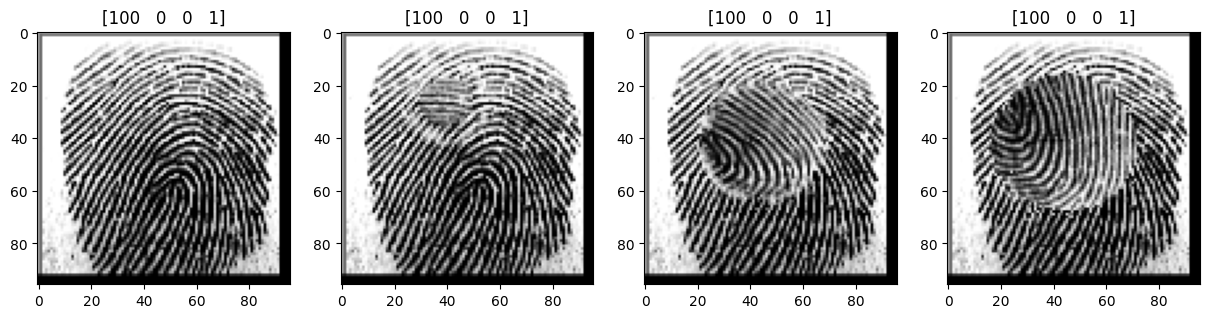

In [31]:
# loading the dataset

x_real = np.load('datasets/x_real.npy')
y_real = np.load('datasets/y_real.npy')
x_easy = np.load('datasets/x_easy.npy')
y_easy = np.load('datasets/y_easy.npy')
x_medium = np.load('datasets/x_medium.npy')
y_medium = np.load('datasets/y_medium.npy')
x_hard = np.load('datasets/x_hard.npy')
y_hard = np.load('datasets/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

### Train Test Split


In [32]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

print(len(x_data))
print(len(label_data))

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size= 0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

42814
42814
(42814, 96, 96) (42814, 4)
(38532, 96, 96) (38532, 4)
(4282, 96, 96) (4282, 4)


### Preview augmentation

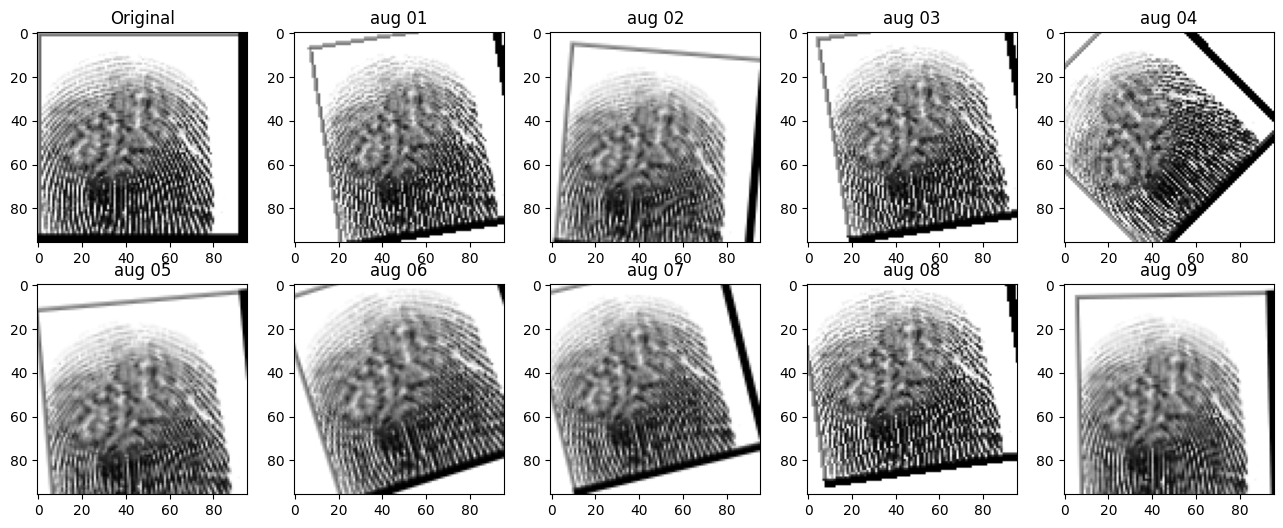

In [33]:
augs = [x_data[40000]]*9

seq = iaa.Sequential([
    #Blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        #scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        #translate by -10 to +10% of their height/width (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        #rotate by -45 to +45 degrees
        rotate=(-45, 45),
        #use nearest neighbour or bilinear interpolation (fast)
        order=[0,1],
        #if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16,6))
plt.subplot(2,5,1)
plt.title('Original')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2,5,i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

### Make Label Dictionary Lookup table

In [34]:
Label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)
    
    Label_real_dict[key] = i

In [35]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x,  label,X_real, Label_real_dict, batch_size= 32, shuffle=True):
        "Initialization"
        self.x = x
        self.label = label
        self.x_real = x_real
        self.Label_real_dict = Label_real_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        "denotes the number of batches per epoch"
        return int(np.floor(len(self.x)/self.batch_size))
    
    def __getitem__(self, index):
        "Generates one batch of data"
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 96, 96), dtype = np.float32)
        y_batch = np.empty((self.batch_size), dtype = np.float32)
        
        #augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-45, 45),
                    order = [0,1],
                    cval = 255
                ),
                iaa.Add((-10, 10)),
                iaa.Multiply((0.5, 1.5)),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5)
            ], random_order= True)
            
            x1_batch = seq.augment_images(x1_batch)
            
    # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
    # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)
            
            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.Label_real_dict[match_key]]
                y_batch[i] = 1.
                
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_index = random.choice(list(self.Label_real_dict.items()))
                    
                    if unmatch_key != match_key:
                        break
                
                x2_batch[i] = self.x_real[unmatch_index]
                y_batch[i] = 0.
    
        return [x1_batch.astype(np.float32)/255., x2_batch.astype(np.float32)/255.], y_batch
    
    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)


In [36]:
train_gen = DataGenerator(x_train, label_train,x_real, Label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, Label_real_dict, shuffle=False)

### Creating Model 1

In [37]:
x1 = layers.Input(shape=(96,96,1))
x2 = layers.Input(shape=(96,96,1))

#share weights across both inputs
inputs = layers.Input(shape=(96,96,1))

feature = layers.Conv2D(32, kernel_size= 3, padding= 'same', activation= 'relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size= 3, padding= 'same', activation= 'relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs= inputs, outputs= feature)

# Two feature models that share weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

#Subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size= 3, padding= 'same', activation= 'relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation= 'sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics=['acc'])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 model_4 (Functional)        (None, 24, 24, 32)           9568      ['input_7[0][0]',             
                                                                     'input_8[0][0]']             
                                                                                                  
 subtract_1 (Subtract)       (None, 24, 24, 32)           0         ['model_4[0][0]',       

### Training the model 1

In [38]:
history_M1 = model.fit_generator(train_gen, epochs = 15, validation_data=val_gen)

C:\Users\omgha\AppData\Local\Temp\ipykernel_36892\2400440274.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_M1 = model.fit_generator(train_gen, epochs = 15, validation_data=val_gen)


Epoch 1/15
1204/1204 [==============================] - 202s 166ms/step - loss: 0.5366 - acc: 0.7069 - val_loss: 0.3142 - val_acc: 0.8795
Epoch 2/15
1204/1204 [==============================] - 189s 157ms/step - loss: 0.3759 - acc: 0.8314 - val_loss: 0.2028 - val_acc: 0.9295
Epoch 3/15
1204/1204 [==============================] - 189s 157ms/step - loss: 0.3112 - acc: 0.8669 - val_loss: 0.1881 - val_acc: 0.9319
Epoch 4/15
1204/1204 [==============================] - 190s 158ms/step - loss: 0.2692 - acc: 0.8904 - val_loss: 0.1227 - val_acc: 0.9678
Epoch 5/15
1204/1204 [==============================] - 188s 156ms/step - loss: 0.2422 - acc: 0.9037 - val_loss: 0.1109 - val_acc: 0.9641
Epoch 6/15
1204/1204 [==============================] - 186s 155ms/step - loss: 0.2228 - acc: 0.9112 - val_loss: 0.1104 - val_acc: 0.9688
Epoch 7/15
1204/1204 [==============================] - 181s 151ms/step - loss: 0.2081 - acc: 0.9185 - val_loss: 0.1219 - val_acc: 0.9598
Epoch 8/15
1204/1204 [============

### Evaluation

1/1 [==============================] - 0s 48ms/step


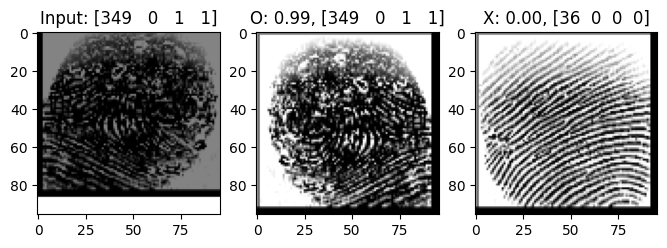

In [39]:

random_idx = random.randint(0, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    ),
    iaa.Add((-10, 10)),
    iaa.Multiply((0.5, 1.5)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5)
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 96, 96, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[Label_real_dict[match_key]].reshape((1, 96, 96)).astype(np.float32) / 255.
ry = y_real[Label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])


# unmatched image
unmatch_key, unmatch_idx = random.choice(list(Label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 96, 96)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')

In [40]:
model.save('FpM_Model_sub.h5')

C:\Users\omgha\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
import time
i = 0
time_taken = []
accuracy = []
while i < 100:
    start = time.time()
    
    random_idx = random.randint(0, len(x_val))

    random_img = x_val[random_idx]
    random_label = label_val[random_idx]

    seq = iaa.Sequential([
        iaa.GaussianBlur(sigma=(0, 0.5)),
        iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-30, 30),
            order=[0, 1],
            cval=255
        )
    ], random_order=True)

    random_img = seq.augment_image(random_img).reshape((1, 96, 96, 1)).astype(np.float32) / 255.

    # matched image
    match_key = random_label.astype(str)
    match_key = ''.join(match_key).zfill(6)

    rx = x_real[Label_real_dict[match_key]].reshape((1, 96, 96)).astype(np.float32) / 255.
    ry = y_real[Label_real_dict[match_key]]

    pred_rx = model.predict([random_img, rx])
    
    end = time.time()
    time_taken.append(end - start)
    accuracy.append(pred_rx)
    i+=1    

1/1 [==============================] - 0s 30ms/step


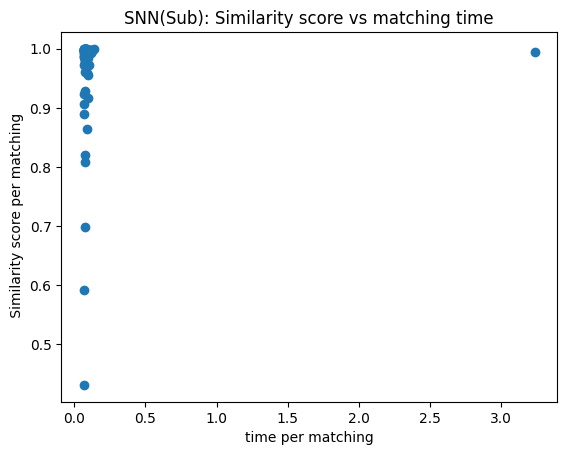

In [42]:
plt.title("SNN(Sub): Similarity score vs matching time")
plt.xlabel("time per matching")
plt.ylabel(" Similarity score per matching")
plt.scatter(time_taken, accuracy)
plt.show()

### Creating Model 2

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Input layers for two fingerprint images
x1 = layers.Input(shape=(96, 96, 1))
x2 = layers.Input(shape=(96, 96, 1))

# Shared CNN feature extractor for both inputs
inputs = layers.Input(shape=(96, 96, 1))
feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

# Feature extraction model
feature_model = Model(inputs=inputs, outputs=feature)

# Apply the same CNN to both inputs
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# Flatten the feature maps before computing the distance
x1_net = layers.Flatten()(x1_net)
x2_net = layers.Flatten()(x2_net)

# Calculate the L1 Distance between the two feature vectors
l1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([x1_net, x2_net])

# Fully connected layers to predict whether the fingerprints match
net = layers.Dense(64, activation='relu')(l1_distance)
net = layers.Dense(1, activation='sigmoid')(net)

# Define the final model
model_2 = Model(inputs=[x1, x2], outputs=net)

# Compile the model with binary crossentropy and Adam optimizer
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
model_2.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 model_6 (Functional)        (None, 24, 24, 32)           9568      ['input_10[0][0]',            
                                                                     'input_11[0][0]']            
                                                                                                  
 flatten_4 (Flatten)         (None, 18432)                0         ['model_6[0][0]']       

### Training the model 2

In [45]:
history_M2 = model_2.fit_generator(train_gen, epochs = 15, validation_data=val_gen)

C:\Users\omgha\AppData\Local\Temp\ipykernel_36892\744114852.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_M2 = model_2.fit_generator(train_gen, epochs = 15, validation_data=val_gen)


Epoch 1/15
1204/1204 [==============================] - 214s 178ms/step - loss: 0.4321 - accuracy: 0.7971 - val_loss: 0.9141 - val_accuracy: 0.5648
Epoch 2/15
1204/1204 [==============================] - 208s 173ms/step - loss: 0.4266 - accuracy: 0.7999 - val_loss: 0.8888 - val_accuracy: 0.5592
Epoch 3/15
1204/1204 [==============================] - 213s 177ms/step - loss: 0.4110 - accuracy: 0.8103 - val_loss: 0.8150 - val_accuracy: 0.5714
Epoch 4/15
1204/1204 [==============================] - 215s 178ms/step - loss: 0.4111 - accuracy: 0.8096 - val_loss: 0.9760 - val_accuracy: 0.5517
Epoch 5/15
1204/1204 [==============================] - 214s 178ms/step - loss: 0.3992 - accuracy: 0.8170 - val_loss: 1.0097 - val_accuracy: 0.5677
Epoch 6/15
1204/1204 [==============================] - 227s 188ms/step - loss: 0.3986 - accuracy: 0.8192 - val_loss: 0.8740 - val_accuracy: 0.5778
Epoch 7/15
1204/1204 [==============================] - 203s 169ms/step - loss: 0.3921 - accuracy: 0.8205 - val_

In [46]:
import time
i = 0
time_taken_2 = []
accuracy_2 = []
while i < 100:
    start = time.time()
    
    random_idx = random.randint(0, len(x_val))

    random_img = x_val[random_idx]
    random_label = label_val[random_idx]

    seq = iaa.Sequential([
        iaa.GaussianBlur(sigma=(0, 0.5)),
        iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-30, 30),
            order=[0, 1],
            cval=255
        )
    ], random_order=True)

    random_img = seq.augment_image(random_img).reshape((1, 96, 96, 1)).astype(np.float32) / 255.

    # matched image
    match_key = random_label.astype(str)
    match_key = ''.join(match_key).zfill(6)

    rx = x_real[Label_real_dict[match_key]].reshape((1, 96, 96)).astype(np.float32) / 255.
    ry = y_real[Label_real_dict[match_key]]

    pred_rx = model_2.predict([random_img, rx])
    
    end = time.time()
    time_taken_2.append(end - start)
    accuracy_2.append(pred_rx)
    i+=1    

1/1 [==============================] - 0s 23ms/step


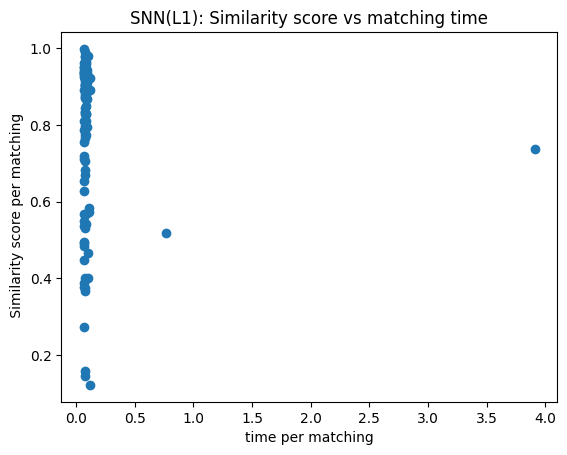

In [47]:
plt.title("SNN(L1): Similarity score vs matching time")
plt.xlabel("time per matching")
plt.ylabel(" Similarity score per matching")
plt.scatter(time_taken_2, accuracy_2)
plt.show()

In [48]:
SNN_l1_train_accuracy = history_M2.history["accuracy"]
SNN_l1_validation_accuracy = history_M2.history["val_accuracy"]
SNN_l1_train_loss = history_M2.history["loss"]
SNN_l1_validation_loss = history_M2.history["val_loss"]

In [49]:
epochs = range(1, len(SNN_l1_train_accuracy) + 1) 

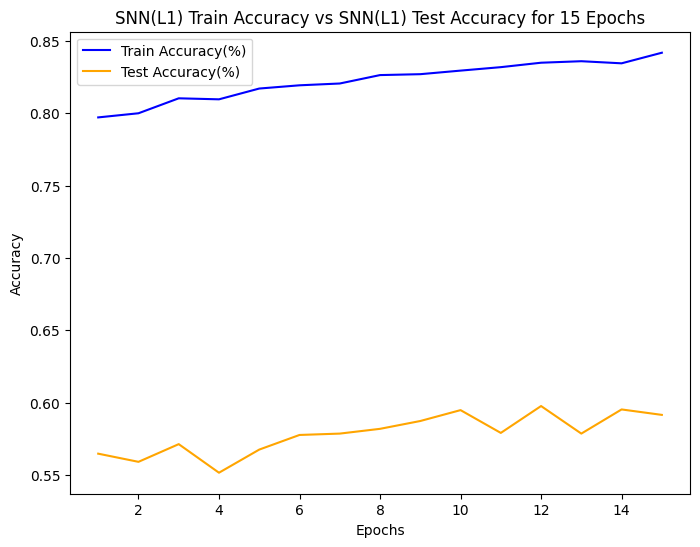

In [50]:
# Plotting Train vs Test Accuracy
plt.figure(figsize=(8, 6))

# Plot Train Accuracy
plt.plot(epochs, SNN_l1_train_accuracy, label='Train Accuracy(%)', color='blue')

# Plot Test Accuracy
plt.plot(epochs, SNN_l1_validation_accuracy, label='Test Accuracy(%)', color='orange')

# Adding title and labels
plt.title('SNN(L1) Train Accuracy vs SNN(L1) Test Accuracy for 15 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


In [51]:
SNN_sub_train_accuracy = history_M1.history['acc']
SNN_sub_validation_accuracy = history_M1.history['val_acc']
SNN_sub_train_loss = history_M1.history['loss']
SNN_sub_validation_loss = history_M1.history['val_loss']

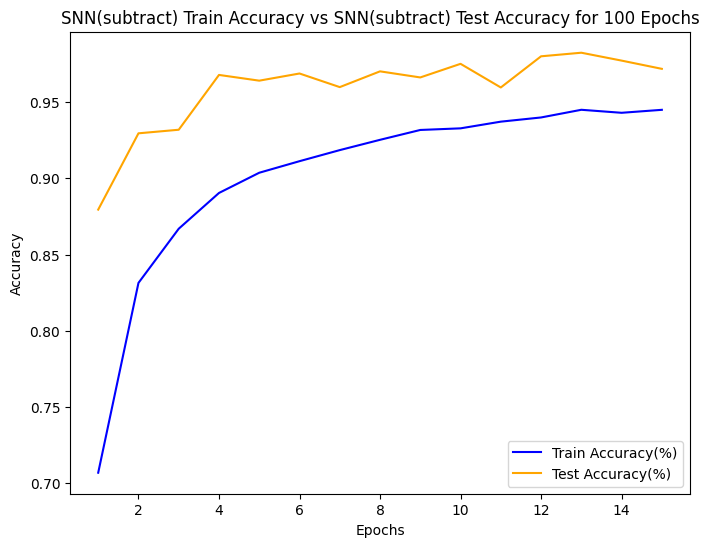

In [52]:
# Plotting Train vs Test Accuracy
plt.figure(figsize=(8, 6))

# Plot Train Accuracy
plt.plot(epochs, SNN_sub_train_accuracy, label='Train Accuracy(%)', color='blue')

# Plot Test Accuracy
plt.plot(epochs, SNN_sub_validation_accuracy, label='Test Accuracy(%)', color='orange')

# Adding title and labels
plt.title('SNN(subtract) Train Accuracy vs SNN(subtract) Test Accuracy for 100 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


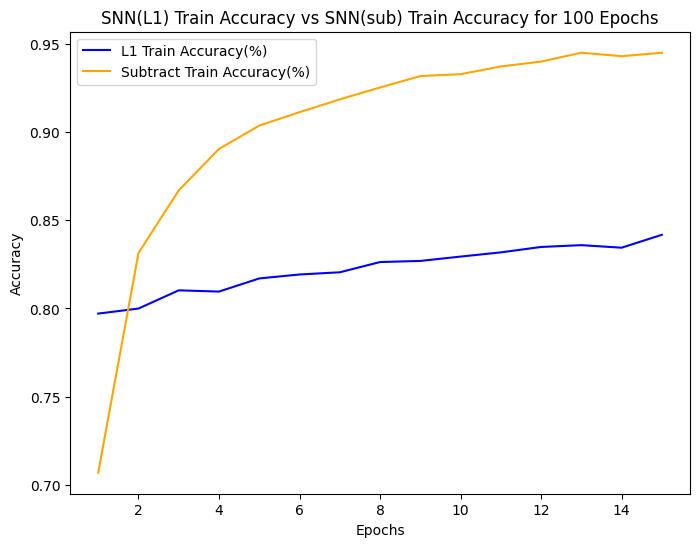

In [53]:
# Plotting Train vs Test Accuracy
plt.figure(figsize=(8, 6))

# Plot Train Accuracy
plt.plot(epochs, SNN_l1_train_accuracy, label='L1 Train Accuracy(%)', color='blue')

# Plot Test Accuracy
plt.plot(epochs, SNN_sub_train_accuracy, label='Subtract Train Accuracy(%)', color='orange')

# Adding title and labels
plt.title('SNN(L1) Train Accuracy vs SNN(sub) Train Accuracy for 100 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


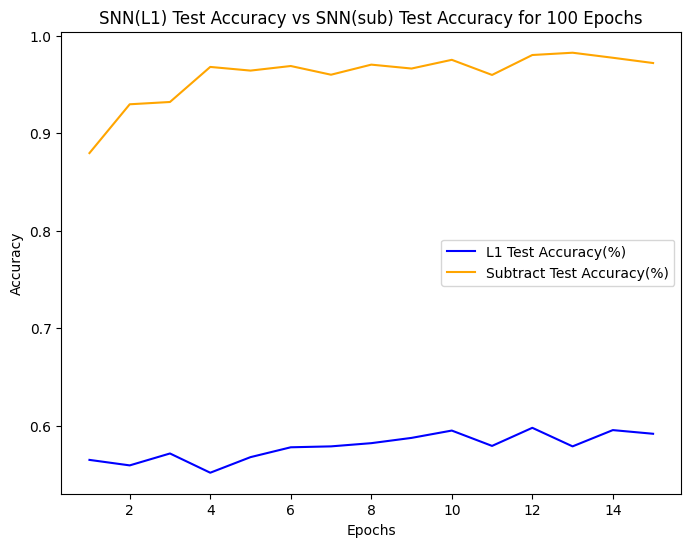

In [54]:
# Plotting Train vs Test Accuracy
plt.figure(figsize=(8, 6))

# Plot Train Accuracy
plt.plot(epochs, SNN_l1_validation_accuracy, label='L1 Test Accuracy(%)', color='blue')

# Plot Test Accuracy
plt.plot(epochs, SNN_sub_validation_accuracy, label='Subtract Test Accuracy(%)', color='orange')

# Adding title and labels
plt.title('SNN(L1) Test Accuracy vs SNN(sub) Test Accuracy for 100 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


In [55]:
model.save('FpM_Model_sub.tflite')

INFO:tensorflow:Assets written to: FpM_Model_sub.tflite\assets


INFO:tensorflow:Assets written to: FpM_Model_sub.tflite\assets


## CNN models

### AlexNet

In [56]:
import torch
import tensorflow as tf

In [ ]:

# Raw Dataset Directory
data_dir = pathlib.Path("./flower_photos")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
# classnames in the dataset specified
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" ])
print(CLASS_NAMES)
# print length of class names
output_class_units = len(CLASS_NAMES)
print(output_class_units)

In [ ]:
model_3_AN = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  # To Flatten layer
  tf.keras.layers.Flatten(),
  # To FC layer 1
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  #To FC layer 2
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(output_class_units, activation='softmax')
])

In [ ]:

model_AN = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_AN.eval()

In [ ]:
model_RN18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_RN18.eval()

In [ ]:
model_RN34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model_RN34.eval()

In [ ]:
model_RN50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_RN50.eval()

In [ ]:
model_GN = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model_GN.eval()